Step 3. Run a multi-scenario optimization for GHG vs. generation-side charges.

This process creates SimulationOptimization and MultiScenarioOptimization objects in http://localhost:8000/admin/optimization/ along with associated DER simulations and cost calculations.

In [1]:
import os, sys
PWD = os.getenv('PWD')
os.chdir(PWD)
sys.path.insert(0, os.getenv('PWD'))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()

In [2]:
from datetime import datetime, timedelta

from beo_datastore.libs.battery import Battery
from beo_datastore.libs.battery_schedule import create_fixed_schedule, optimize_battery_schedule
from beo_datastore.libs.plot_intervalframe import (
        plot_frame288, plot_frame288_monthly_comparison, plot_intervalframe, plot_many_frame288s
)

from cost.ghg.models import GHGRate
from cost.optimization.models import MultiScenarioOptimization, SimulationOptimization
from cost.utility_rate.models import RatePlan
from der.simulation.models import BatteryConfiguration, BatteryStrategy
from load.customer.models import CustomerCluster

See http://localhost:8888/notebooks/demo/1_create_kmeans_clusters.ipynb to create CustomerClusters and http://localhost:8888/notebooks/demo/2_create_battery_and_battery_schdule.ipynb to create BatteryConfigurations and BatterySchedules.

In [3]:
# the following steps can be also performed via Django admin at http://localhost:8000/admin/optimization/

# create multi-scenario optimization
multi = MultiScenarioOptimization.objects.create()

# create simulation optimizations and add them to a multi-scenario optimization
for config in [BatteryConfiguration.objects.first()]:
    for strategy in [BatteryStrategy.objects.get(id=1), BatteryStrategy.objects.get(id=2)]:
        single, _ = SimulationOptimization.objects.get_or_create(
            start=datetime(2018, 1, 1),
            end_limit=datetime(2019, 1, 1),
            battery_strategy=strategy,
            battery_configuration=config,
            rate_plan=RatePlan.objects.filter(name__contains="E-19").first(),
        )
        single.customer_clusters.add(CustomerCluster.objects.first())
        single.ghg_rates.add(*GHGRate.objects.filter(name="Clean Net Short"))
        single.ghg_rates.add(*GHGRate.objects.filter(name="CARB - Unspecified Power"))
        multi.simulation_optimizations.add(single)

In [4]:
# as an alternative, you can retrieve an existing multi-scenario optimization
# multi = MultiScenarioOptimization.objects.get(id=1)

In [5]:
# this step kicks off all battery simulations and cost calculations
multi.run(multiprocess=True)

In [6]:
# display all bill and GHG impacts from every single simulation optimization
display(multi.detailed_report)

,UsagePreDER,UsagePostDER,UsageDelta,BillPreDER,BillPostDER,BillDelta,CleanNetShort2018PreDER,CleanNetShort2018PostDER,CleanNetShort2018Delta,CleanNetShort2022PreDER,...,CleanNetShort2030Delta,CARB-UnspecifiedPower2013PreDER,CARB-UnspecifiedPower2013PostDER,CARB-UnspecifiedPower2013Delta,SimulationOptimization,BatteryConfiguration,BatteryStrategy,SimulationRatePlan,Location,Building Type
ID,,,,,,,,,,,,,,,,,,,,,
4,5.553059e+06,5.577843e+06,24783.333333,850465.283039,831404.127236,-19061.155803,2137.182627,2149.211793,12.029166,1699.561852,...,68.386524,2376.709387,2387.316654,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Alturas,Full Service Restaurant
4,5.553059e+06,5.585559e+06,32500.000000,850465.283039,858574.082440,8108.799401,2137.182627,2147.400476,10.217849,1699.561852,...,-27.546635,2376.709387,2390.619387,13.910000,2,150kW @ 4 hours (90.0% efficiency),Minimize Clean Net Short 2030 - charge to None...,"E-19 (Primary, Voluntary)",Alturas,Full Service Restaurant
23,5.293307e+06,5.318090e+06,24783.333333,823679.503474,805032.277738,-18647.225735,2038.580863,2050.610029,12.029166,1615.911779,...,68.386524,2265.535200,2276.142466,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Arcata AP,Large Office
23,5.293307e+06,5.325807e+06,32500.000000,823679.503474,834606.934918,10927.431444,2038.580863,2048.798712,10.217849,1615.911779,...,-27.546635,2265.535200,2279.445200,13.910000,2,150kW @ 4 hours (90.0% efficiency),Minimize Clean Net Short 2030 - charge to None...,"E-19 (Primary, Voluntary)",Arcata AP,Large Office
39,6.368652e+06,6.393436e+06,24783.333333,954063.471054,933583.900763,-20479.570291,2450.714769,2462.743935,12.029166,1931.455145,...,68.386524,2725.783190,2736.390457,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Bakersfield-Meadows Field,Large Office
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,6.485261e+06,6.510044e+06,24783.333333,966491.769363,946678.220781,-19813.548582,2496.342582,2508.371747,12.029166,1962.760989,...,68.386524,2775.691523,2786.298789,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Van Nuys AP,Large Office
1143,6.168376e+06,6.200876e+06,32500.000000,929550.132055,939853.859908,10303.727853,2374.163074,2384.380923,10.217849,1874.194250,...,-27.546635,2640.064781,2653.974781,13.910000,2,150kW @ 4 hours (90.0% efficiency),Minimize Clean Net Short 2030 - charge to None...,"E-19 (Primary, Voluntary)",Visalia Muni AWOS,Large Office
1143,6.168376e+06,6.193159e+06,24783.333333,929550.132055,912489.196077,-17060.935978,2374.163074,2386.192240,12.029166,1874.194250,...,68.386524,2640.064781,2650.672048,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Visalia Muni AWOS,Large Office


In [7]:
# this step can be run using different filtering criteria

# remove all existing filters
multi.initialize()

# filter simulations
multi.filter_by_query("BillDelta < -1")  # include only BillDelta < -1
multi.filter_by_transform("CleanNetShort2030Delta", min)  # limit results to min CleanNetShort2030Delta values 

In [8]:
# display bill and GHG impacts
display(multi.detailed_report)

,UsagePreDER,UsagePostDER,UsageDelta,BillPreDER,BillPostDER,BillDelta,CleanNetShort2018PreDER,CleanNetShort2018PostDER,CleanNetShort2018Delta,CleanNetShort2022PreDER,...,CleanNetShort2030Delta,CARB-UnspecifiedPower2013PreDER,CARB-UnspecifiedPower2013PostDER,CARB-UnspecifiedPower2013Delta,SimulationOptimization,BatteryConfiguration,BatteryStrategy,SimulationRatePlan,Location,Building Type
4,5.553059e+06,5.577843e+06,24783.333333,850465.283039,831404.127236,-19061.155803,2137.182627,2149.211793,12.029166,1699.561852,...,68.386524,2376.709387,2387.316654,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Alturas,Full Service Restaurant
23,5.293307e+06,5.318090e+06,24783.333333,823679.503474,805032.277738,-18647.225735,2038.580863,2050.610029,12.029166,1615.911779,...,68.386524,2265.535200,2276.142466,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Arcata AP,Large Office
39,6.368652e+06,6.393436e+06,24783.333333,954063.471054,933583.900763,-20479.570291,2450.714769,2462.743935,12.029166,1931.455145,...,68.386524,2725.783190,2736.390457,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Bakersfield-Meadows Field,Large Office
55,6.471160e+06,6.495943e+06,24783.333333,960144.123177,940295.182218,-19848.940959,2490.804297,2502.833463,12.029166,1965.181354,...,68.386524,2769.656446,2780.263713,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Barstow Daggett AP,Large Office
71,6.214737e+06,6.239520e+06,24783.333333,934781.851997,917120.678620,-17661.173377,2391.815906,2403.845071,12.029166,1890.639499,...,68.386524,2659.907438,2670.514705,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Beale AFB,Large Office
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,6.555937e+06,6.580720e+06,24783.333333,985146.769710,962985.479920,-22161.289790,2523.262358,2535.291523,12.029166,1999.933003,...,68.386524,2805.940982,2816.548249,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Twentynine Palms,Large Office
1111,6.014771e+06,6.039554e+06,24783.333333,928505.911635,906244.719226,-22261.192409,2314.178324,2326.207489,12.029166,1823.622298,...,68.386524,2574.321921,2584.929187,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Ukiah Muni AP,Large Office
1127,6.485261e+06,6.510044e+06,24783.333333,966491.769363,946678.220781,-19813.548582,2496.342582,2508.371747,12.029166,1962.760989,...,68.386524,2775.691523,2786.298789,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Van Nuys AP,Large Office
1143,6.168376e+06,6.193159e+06,24783.333333,929550.132055,912489.196077,-17060.935978,2374.163074,2386.192240,12.029166,1874.194250,...,68.386524,2640.064781,2650.672048,10.607267,1,150kW @ 4 hours (90.0% efficiency),Minimize E-19 energy weekday - charge to None ...,"E-19 (Primary, Voluntary)",Visalia Muni AWOS,Large Office


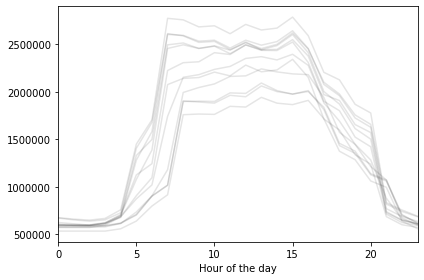

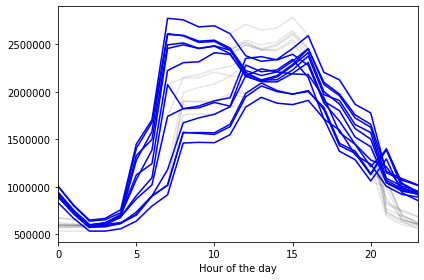

In [9]:
# plot all meters in study (combined into a single load profile)
frame288_type = "total_frame288"

# plot all meters combined before battery
plot_frame288(multi.pre_DER_intervalframe.total_frame288)
# compare all meteres combined after battery with before battery
plot_many_frame288s(
    [getattr(multi.pre_DER_intervalframe, frame288_type)],
    getattr(multi.post_DER_intervalframe, frame288_type),
)

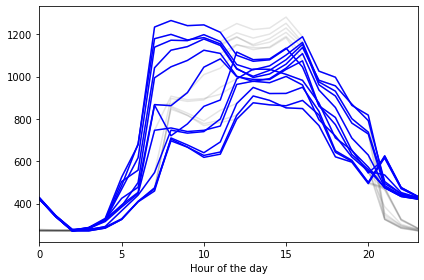

None

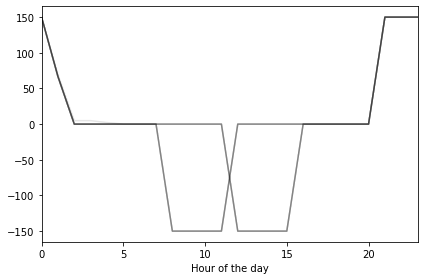

None

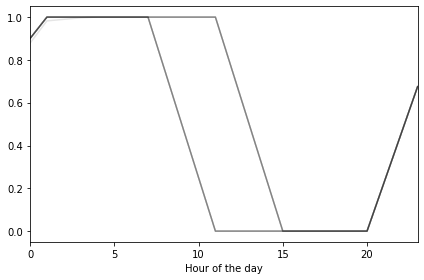

None

In [10]:
id_ = 1111

# examine battery operations for a single meter
battery_simulation = multi.battery_simulations.get(meter_intervalframe__id=id_)

# display average daily load before battery
display(plot_many_frame288s(
    [battery_simulation.pre_intervalframe.average_frame288],
    battery_simulation.post_intervalframe.average_frame288
))

# display average battery discharge
display(plot_frame288(battery_simulation.intervalframe.average_frame288))

# display average battery state of charge
display(plot_frame288(battery_simulation.average_state_of_charge_frame288))

In [11]:
# view individual before and after bills
bill_calculation = multi.bill_calculations.get(battery_simulation__meter_intervalframe__id=id_)
bill_comparison = bill_calculation.bill_comparisons.get(start=datetime(2018, 7, 1))

display(bill_comparison.pre_DER_validation_bill.total_dataframe)
display(bill_comparison.post_DER_validation_bill.total_dataframe)

,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,fixed,Fixed Charge First Meter,,1.000000,month,140,$/month,1,140.000000
1,energy,Energy Charge,1,264314.496152,kWh,0.07369,$/kWh,1,19477.335221
2,energy,Energy Charge,3,164347.979827,kWh,0.09849,$/kWh,1,16186.632533
3,energy,Energy Charge,4,155476.593573,kWh,0.14013,$/kWh,1,21786.935057
4,demand,Demand Charge,2,1459.606278,kW,3.56,$/kW,1,5196.198351
5,demand,Demand Charge,3,1581.825569,kW,16.67,$/kW,1,26369.032241
6,demand,Flat Demand Charge,0,1581.825569,kW,9.72,$/kW,1,15375.344534
Total,,,,588763.326969,,,,,104531.477938


,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,fixed,Fixed Charge First Meter,,1.000000,month,140,$/month,1,140.000000
1,energy,Energy Charge,1,279581.162818,kWh,0.07369,$/kWh,1,20602.335888
2,energy,Energy Charge,3,164347.979827,kWh,0.09849,$/kWh,1,16186.632533
3,energy,Energy Charge,4,142276.593573,kWh,0.14013,$/kWh,1,19937.219057
4,demand,Demand Charge,2,1459.606278,kW,3.56,$/kW,1,5196.198351
5,demand,Demand Charge,3,1441.718281,kW,16.67,$/kW,1,24033.443750
6,demand,Flat Demand Charge,0,1480.915901,kW,9.72,$/kW,1,14394.502560
Total,,,,590588.976680,,,,,100490.332139


In [12]:
# view individual before and after monthly GHG emissions
ghg_calculation = multi.ghg_calculations.get(battery_simulation__meter_intervalframe__id=id_, ghg_rate__name="Clean Net Short", ghg_rate__effective__year=2030)
display(ghg_calculation.aggregate_ghg_calculation.comparison_table)

,before,after
1,108.855374,114.349229
2,85.036341,90.284864
3,105.446867,111.423083
4,88.284559,96.237462
5,109.164525,114.993996
6,101.411595,108.912698
7,124.633912,130.501608
8,154.921457,158.986567
9,158.079392,161.654292
10,111.495930,117.045413
